# Old STF Partials Generation

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_partial_derivatives(device='cpu', plot=False):
    # Define constants for Tuff/Rhyolite based on the given table
    h0 = torch.tensor(122.0, requires_grad=False, device=device)
    R0 = torch.tensor(202.0, requires_grad=False, device=device)
    gamma0 = torch.tensor(1.0, requires_grad=False, device=device)  # assuming a value for gamma0
    P10 = torch.tensor(3.6E6, requires_grad=False, device=device)
    P20 = torch.tensor(5.0E6, requires_grad=False, device=device)
    C = torch.tensor(3500.0, requires_grad=False, device=device)
    n = torch.tensor(2.4, requires_grad=False, device=device)
    lambda_ = torch.tensor(1.0, requires_grad=False, device=device)  # assuming a value for lambda
    mu = torch.tensor(1.0, requires_grad=False, device=device)  # assuming a value for mu

    # Define h, W, t as tensors with requires_grad=True to compute derivatives
    h = torch.tensor(150.0, requires_grad=True, device=device)  # example value
    w = torch.tensor(1.0, requires_grad=True, device=device)  # given value
    t = torch.linspace(0, 1.0, steps=100, requires_grad=True, device=device)  # given final time of 1.0

    # Define H(t), Heaviside step function
    H_t = (t >= 0).float()

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lambda_ + 2 * mu) / (4 * mu)

    # Ensure beta is not zero to avoid division by zero
    beta = torch.clamp(beta, min=1e-6)

    # Compute w0 based on the given equation
    w0 = C / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    # Ensure alpha is not zero to avoid division by zero
    alpha = torch.clamp(alpha, min=1e-6)

    # Calculate and print the expression inside the square root
    sqrt_input = 1 / (2 * beta) - 1 / (4 * beta**2)
    print(f'sqrt_input: {sqrt_input}')

    # Ensure sqrt_input is non-negative to avoid NaN values
    sqrt_input = torch.clamp(sqrt_input, min=1e-6)

    p = w0 * torch.sqrt(sqrt_input)

    # Debugging: Print intermediate values
    print(f'R_el: {R_el}')
    print(f'gamma: {gamma}')
    print(f'beta: {beta}')
    print(f'w0: {w0}')
    print(f'alpha: {alpha}')
    print(f'p: {p}')

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (C**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)

    # # Define B(t) based on equation (2)
    # def B_t(R_el, t):
    #     P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
    #     P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
    #     return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t
    
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + (1-torch.exp(-gamma * t))*P2_t) * H_t # fixed

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = torch.autograd.grad(f_t_val.sum(), t, create_graph=True)[0]

    # Reshape for conv1d: [batch_size, in_channels, sequence_length]
    df_dt_reshaped = df_dt.view(1, 1, -1)
    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(1, 1, -1)

    # Perform convolution using conv1d
    S_t_conv = F.conv1d(-df_dt_reshaped, B_t_reshaped, padding='same')
    
    S_t = S_t_conv.view(-1)[:t.size(0)]  # Ensure S_t has the same length as t

    if plot:
        # Convert S_t, f_t_val, and B_t_val to CPU for plotting
        S_t_cpu = S_t.detach().cpu().numpy()
        f_t_cpu = f_t_val.detach().cpu().numpy()
        B_t_cpu = B_t_val.detach().cpu().numpy()
        t_cpu = t.detach().cpu().numpy()

        # Plot S(t) on primary y-axis and f(t) on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, S_t_cpu, label='S(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('S(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, f_t_cpu, label='f(t)', color='tab:orange')
        ax2.set_ylabel('f(t)', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title('Plots of S(t) and f(t)')
        plt.show()

        # Plot B(t) separately
        plt.figure(figsize=(10, 6))
        plt.grid(True)
        plt.plot(t_cpu, B_t_cpu, label='B(t)', color='tab:green')
        plt.xlabel('Time (t)')
        plt.ylabel('B(t)')
        plt.title('Plot of B(t)')
        plt.legend()
        plt.show()

    # Compute dS(t)/dw and dS(t)/dh using autograd
    S_t_sum = S_t.sum()  # sum to get a scalar for backward
    S_t_sum.backward()

    dS_dW = w.grad
    dS_dh = h.grad

    return dS_dW, dS_dh

# Example usage on GPU (if available)
if torch.cuda.is_available():
    dS_dW, dS_dh = compute_partial_derivatives(device='cuda', plot=True)
    print(f'dS/dW (GPU): {dS_dW}')
    print(f'dS/dh (GPU): {dS_dh}')


# New STF Partials Generation

R_el: 185.3374786376953
gamma: 28.337495803833008
beta: 0.7497966289520264
w0: 18.884469985961914
alpha: 12.593061447143555
p: 8.901017189025879
(R_el*pv): 648681.19


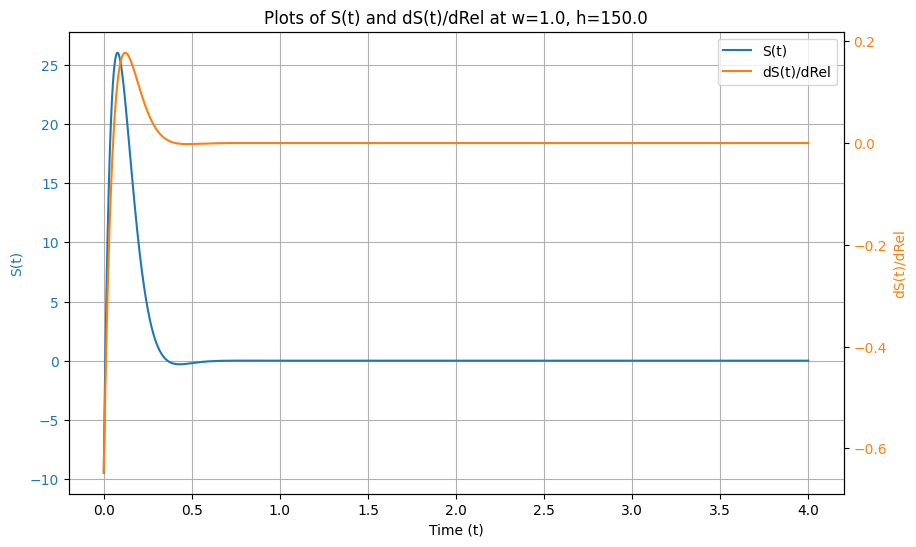

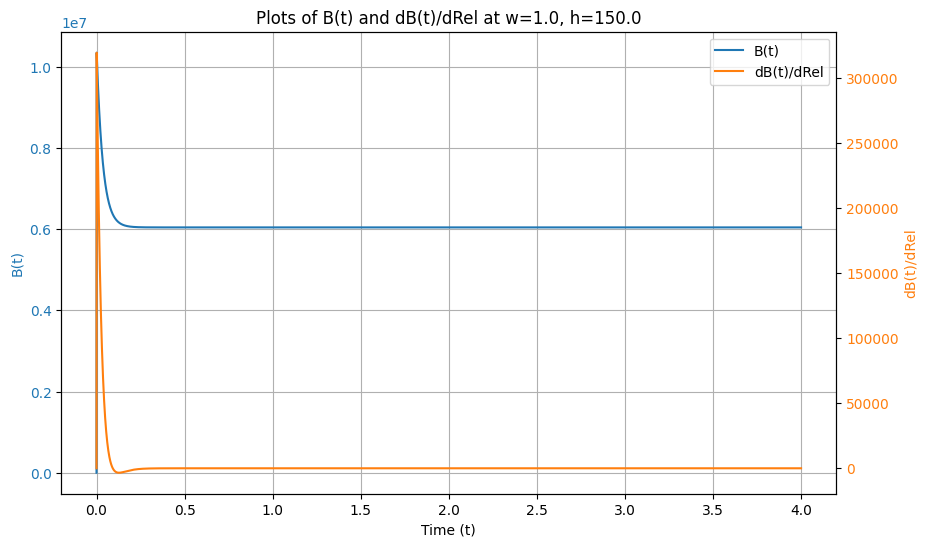

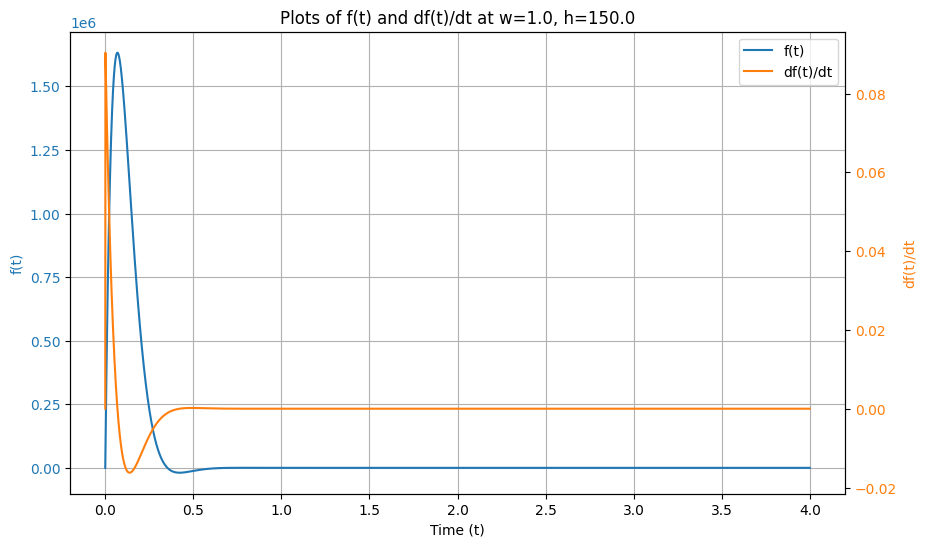

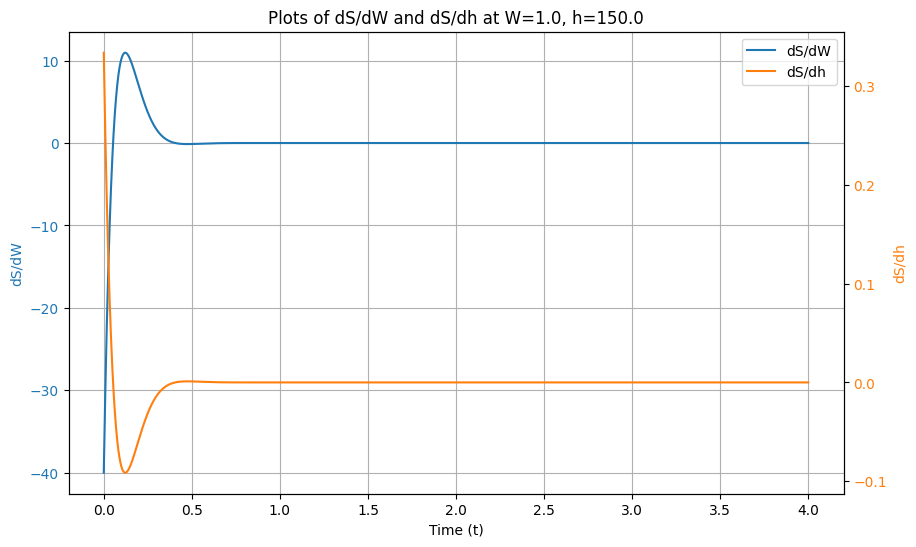

Analytical
dS/dW: 804.9330444335938
dS/dh: -6.707775592803955
Numerical
dS/dW: 2185.47802734375
dS/dh: 2.3969078063964844


{'dS_dW_ana': array([-4.0026588e+01, -3.8832275e+01, -3.7658531e+01, ...,
        -5.2996120e-22, -2.7115671e-22,  0.0000000e+00], dtype=float32),
 'dS_dh_ana': array([ 3.3355486e-01,  3.2360229e-01,  3.1382108e-01, ...,
         4.4163427e-24,  2.2596390e-24, -0.0000000e+00], dtype=float32),
 'df_dt': array([0.0000000e+00, 9.0352505e-02, 8.8072672e-02, ..., 8.7932069e-24,
        8.8590026e-24, 8.9210812e-24], dtype=float32),
 'S_t': array([-9.4668341e+00, -8.2931995e+00, -7.1468148e+00, ...,
        -2.8190216e-22, -1.4227292e-22,  0.0000000e+00], dtype=float32),
 'f_t': array([ 0.0000000e+00,  5.9374094e+04,  1.1725715e+05, ...,
        -7.8864448e-16, -7.8291769e-16, -7.7714950e-16], dtype=float32),
 'B_t': array([       0. , 10345132. , 10224890. , ...,  6042600.5,  6042600.5,
         6042600.5], dtype=float32),
 't': array([0.0000000e+00, 1.0002501e-03, 2.0005002e-03, ..., 3.9979994e+00,
        3.9989998e+00, 4.0000000e+00], dtype=float32),
 'dB_t_dRel': array([ 0.0000000e+00, 

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    "Salt": {
        "h0": 122.0, "R0": 478.0, "gamma0": 31.0, "P10": 5.5E6, "P20": 0.8E6, "pv": 4670.0, "sv": 2696.0, "n": 1.87, "rho": 2200.0
    },
    "Shale": {
        "h0": 122.0, "R0": 265.0, "gamma0": 42.0, "P10": 4.2E6, "P20": 2.5E6, "pv": 4320.0, "sv": 2495.0, "n": 2.4, "rho": 2350.0
    },
    "Wet Tuff": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 2400.0, "sv": 1300.0, "n": 2.4, "rho": 1915.0
    },
    "Wet Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5350.0, "sv": 2795.0, "n": 2.4, "rho": 2650.0
    }
}

# Function to populate variables from the dictionary based on material name
def get_constants(material_name, device):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        h0 = torch.tensor(material_constants["h0"], requires_grad=False, device=device)
        R0 = torch.tensor(material_constants["R0"], requires_grad=False, device=device)
        gamma0 = torch.tensor(material_constants["gamma0"], requires_grad=False, device=device)
        P10 = torch.tensor(material_constants["P10"], requires_grad=False, device=device)
        P20 = torch.tensor(material_constants["P20"], requires_grad=False, device=device)
        pv = torch.tensor(material_constants["pv"], requires_grad=False, device=device)
        sv = torch.tensor(material_constants["sv"], requires_grad=False, device=device)
        n = torch.tensor(material_constants["n"], requires_grad=False, device=device)
        rho = torch.tensor(material_constants["rho"], requires_grad=False, device=device)
        return h0, R0, gamma0, P10, P20, pv, sv, n, rho
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")



def compute_partial_derivatives(w=1.0, h=150.0, material='Tuff/Rhyolite', device='cpu', plot=False):
    h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)
    
    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu   

    # Define h, w, t as tensors with requires_grad=True to compute derivatives
    h = torch.tensor(h, requires_grad=True, device=device) 
    w = torch.tensor(w, requires_grad=True, device=device)  
    t = torch.linspace(0, 4.0, steps=4000, requires_grad=True, device=device) 
    def Heaviside(t):
        return torch.where(t > 0, torch.tensor(1.0), torch.tensor(0.0))

    # Define H(t), Heaviside step function
    H_t = Heaviside(t)

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lam + 2 * mu) / (4 * mu)

    # Compute w0 based on the given equation
    w0 = pv / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    p = w0 * torch.sqrt(1 / (2 * beta) - 1 / (4 * beta**2))

    # Debugging: Print intermediate values
    print(f'R_el: {R_el}')
    print(f'gamma: {gamma}')
    print(f'beta: {beta}')
    print(f'w0: {w0}')
    print(f'alpha: {alpha}')
    print(f'p: {p}')
    print(f'(R_el*pv): {(R_el*pv):.2f}')

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)
    
    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv**2 / (beta * p))
        return A * H_t * torch.exp(-alpha * t) * (-alpha * torch.sin(p * t) + p * torch.cos(p * t))

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t


    def dB_t_dRel_old():
        # Compute the terms of the expression
        term1 = (gamma * torch.exp(-gamma * t) / R_el) * P10 * (h / h0)
        term2 = (torch.exp(-gamma * t) - 3 * (1 - torch.exp(-gamma * t))) / R_el
        term3 = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        
        # Combine the terms
        result = (term1 - term2 * term3) * H_t
        
        return result


    def dB_t_dRel_new():
        term1 = -torch.exp(-gamma * t) * P10 * (h / h0) * (t * gamma / R_el - n / R_el * (h / h0).pow(1/n)) * (h * w.pow(-1/3)).pow(1/3)
        term2 = P20 * w.pow(0.87) * ((t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3) - (t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3))
        term3 = (1 - torch.exp(-gamma * t)) * (1 / 3 * n * R0.pow(2) / R_el.pow(3) * (h0 / h).pow(1/3) * w.pow(-2/3) * (h * w.pow(-1/3)).pow(1/3))
        term4 = (1 - torch.exp(-gamma * t)) * (-3 * R0.pow(3) / R_el.pow(4) * (h0 / h).pow(1/3) * (h * w.pow(-1/3)).pow(1/3))
        return (term1 + term2 + term3 + term4) * H_t


    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h).pow(1/n) * (1 / 3) * w.pow(-2/3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h).pow(1/n) * (1 / h) * w.pow(1/3)

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)
    

    # Reshape for conv1d: [batch_size, channels, sequence_length]
    df_dt_reshaped = df_dt.view(1, 1, -1)

    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(1, 1, -1)


    S_t = F.conv1d(-df_dt_reshaped/(R_el*pv), B_t_reshaped, padding=B_t_reshaped.size(-1)-1) # full convolution padding
    S_t = S_t.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t

    # S_t = F.conv1d(df_dt_reshaped, B_t_reshaped, padding=B_t_reshaped.size(-1)//2) # half convolution padding
    # S_t = S_t.view(-1)[:t.size(0)]  # Ensure S_t has the same length as t


    # Compute dS(t)/dW and dS(t)/dh using autograd
    dS_dW_num = torch.autograd.grad(S_t.sum(), w, create_graph=True)[0]
    dS_dh_num = torch.autograd.grad(S_t.sum(), h, create_graph=True)[0]
    df_dt_num = torch.autograd.grad(f_t_val.sum(), t, create_graph=True)[0]
    
    # dB_t_dRel_val = dB_t_dRel_old()
    dB_t_dRel_val = dB_t_dRel_new()
    dB_t_dRel_reshaped = dB_t_dRel_val.view(1, 1, -1)
    
    # Perform convolution using conv1d
    dS_t_dRel = F.conv1d(-df_dt_reshaped/(R_el*pv), dB_t_dRel_reshaped, padding=dB_t_dRel_reshaped.size(-1)-1) # full convolution padding
    dS_t_dRel = dS_t_dRel.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t

    # dS_t_dRel = F.conv1d(df_dt_reshaped, dB_t_dRel_reshaped, padding=dB_t_dRel_reshaped.size(-1)//2) # half convolution padding
    # dS_t_dRel = dS_t_dRel.view(-1)[:t.size(0)]  # Ensure S_t has the same length as t
    

    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    t_cpu = t.detach().cpu().numpy()
    
    S_t_cpu = S_t.detach().cpu().numpy()
    B_t_cpu = B_t_val.detach().cpu().numpy()
    f_t_cpu = f_t_val.detach().cpu().numpy()
    
    dB_t_dRel_cpu = dB_t_dRel_val.detach().cpu().numpy()
    dS_t_dRel_cpu = dS_t_dRel.detach().cpu().numpy()
    df_dt_cpu = df_dt.detach().cpu().numpy()
    dS_dW_ana_cpu = dS_dW_ana.detach().cpu().numpy()
    dS_dh_ana_cpu = dS_dh_ana.detach().cpu().numpy()
    df_dt_num_cpu = df_dt_num.detach().cpu().numpy()

    
    if plot:
        # Convert S_t, f_t_val, and B_t_val to CPU for plotting
        
        # Plot S(t) on primary y-axis and f(t) on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, S_t_cpu, label='S(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('S(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_t_dRel_cpu, label='dS(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dS(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of S(t) and dS(t)/dRel at w={w.item()}, h={h.item()}')
        plt.show()

        # Plot B(t) on primary y-axis and f(t) on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, B_t_cpu, label='B(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('B(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dB_t_dRel_cpu, label='dB(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dB(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of B(t) and dB(t)/dRel at w={w.item()}, h={h.item()}')
        plt.show()

        # Plot f(t) on primary y-axis and df(t)/dt on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, f_t_cpu, label='f(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('f(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, df_dt_cpu, label='df(t)/dt', color='tab:orange')
        ax2.set_ylabel('df(t)/dt', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of f(t) and df(t)/dt at w={w.item()}, h={h.item()}')
        plt.show()


        # Plot f(t) on primary y-axis and df(t)/dt on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, dS_dW_ana_cpu, label='dS/dW', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('dS/dW', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_dh_ana_cpu, label='dS/dh', color='tab:orange')
        ax2.set_ylabel('dS/dh', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of dS/dW and dS/dh at W={w.item()}, h={h.item()}')
        plt.show()


        print('Analytical')
        print(f'dS/dW: {dS_dW_ana.detach().cpu().numpy().sum()}')
        print(f'dS/dh: {dS_dh_ana.detach().cpu().numpy().sum()}')
        print('Numerical')
        print(f'dS/dW: {dS_dW_num}')
        print(f'dS/dh: {dS_dh_num}')

        out = {
                'dS_dW_ana': dS_dW_ana_cpu,
                'dS_dh_ana': dS_dh_ana_cpu,
                'df_dt': df_dt_cpu,
                'S_t': S_t_cpu,
                'f_t': f_t_cpu,
                'B_t': B_t_cpu,
                't': t_cpu,
                'dB_t_dRel': dB_t_dRel_cpu,
                'dS_t_dRel': dS_t_dRel_cpu,
                'R_el*pv': (R_el*pv).item(),
                'h': h.item(),
                'w': w.item()
                }

        return out
    else:
        out = {
                'dS_dW_ana': dS_dW_ana_cpu,
                'dS_dh_ana': dS_dh_ana_cpu,
                'df_dt': df_dt_cpu,
                'S_t': S_t_cpu,
                'f_t': f_t_cpu,
                'B_t': B_t_cpu,
                't': t_cpu,
                'dB_t_dRel': dB_t_dRel_cpu,
                'dS_t_dRel': dS_t_dRel_cpu,
                'R_el*pv': (R_el*pv).item(),
                'h': h.item(),
                'w': w.item()
                }
        return out


plot = True
material = 'Tuff/Rhyolite' # Tuff/Rhyolite, Granite, Salt, Shale, Wet Tuff, Wet Granite 
# Example usage on GPU (if available)
if torch.cuda.is_available():
    result = compute_partial_derivatives(w=1.0, h=150.0, device='cuda', material=material, plot=plot)
else:
    result = compute_partial_derivatives(w=1.0, h=150.0, device='cpu' , material=material, plot=plot)

    

result

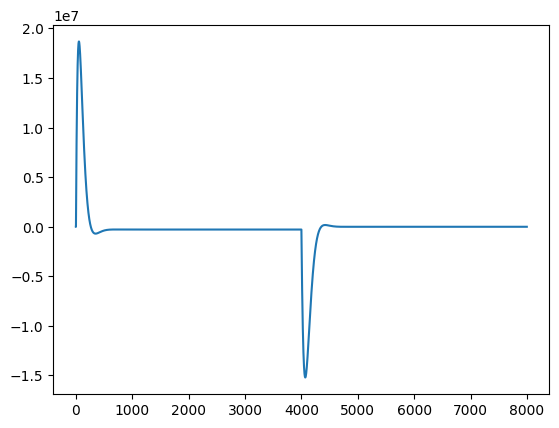

In [75]:
# compare to scipy convolve function
from scipy.signal import convolve
dfdt = result['df_dt']
Bt = result['B_t']

St = convolve(dfdt, Bt, mode='full')
plt.plot(St)
plt.show()

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 276.48907470703125
gamma: 18.995325088500977
beta: 0.7497966289520264
w0: 12.658727645874023
alpha: 8.44144058227539
p: 5.966571807861328
(R_el*pv): 967711.75
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


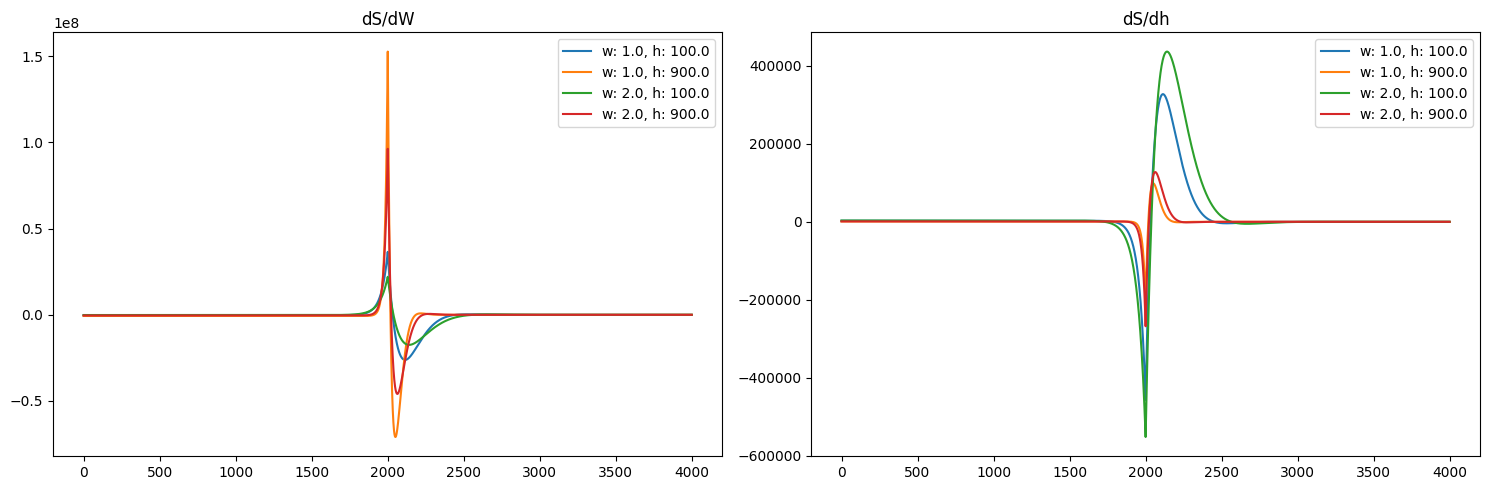

In [76]:
import itertools
ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['dS_dW_ana'])
    out[1].append(result['dS_dh_ana'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('dS/dW')
axs[1].set_title('dS/dh')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()
plt.savefig('dS_dW_dS_dh.png')


R_el: 185.3374786376953
gamma: 28.337495803833008
beta: 0.7497966289520264
w0: 18.884469985961914
alpha: 12.593061447143555
p: 8.901017189025879
(R_el*pv): 648681.19
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 233.51058959960938
gamma: 22.491485595703125
beta: 0.7497966289520264
w0: 14.98861312866211
alpha: 9.995119094848633
p: 7.064741611480713
(R_el*pv): 817287.06
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


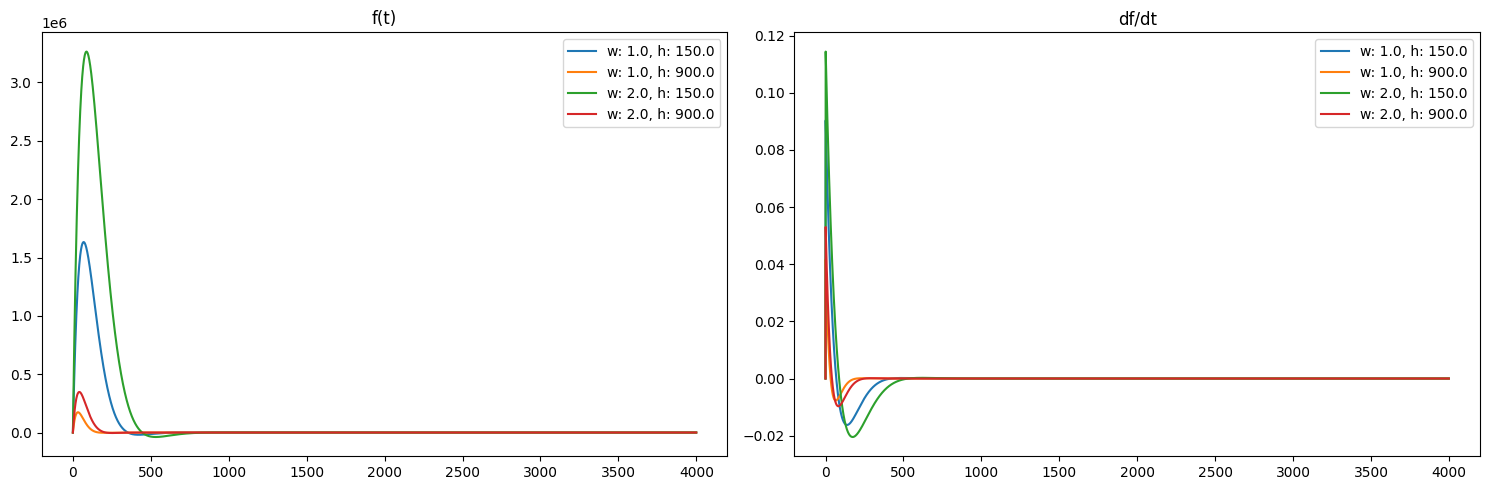

In [77]:

ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['f_t'])
    out[1].append(result['df_dt'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('f(t)')
axs[1].set_title('df/dt')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()
plt.savefig('f_t_df_dt.png')



R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 276.48907470703125
gamma: 18.995325088500977
beta: 0.7497966289520264
w0: 12.658727645874023
alpha: 8.44144058227539
p: 5.966571807861328
(R_el*pv): 967711.75
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


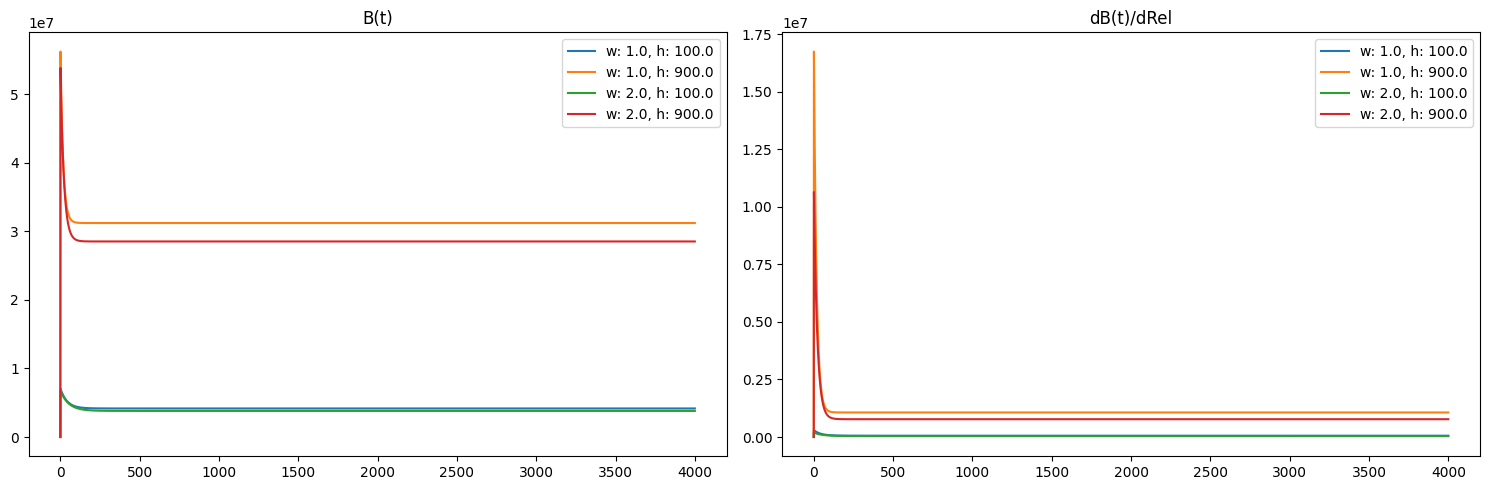

In [78]:

ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['B_t'])
    out[1].append(result['dB_t_dRel'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('B(t)')
axs[1].set_title('dB(t)/dRel')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()

plt.savefig('B_t_dB_t_dRel.png')


R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 276.48907470703125
gamma: 18.995325088500977
beta: 0.7497966289520264
w0: 12.658727645874023
alpha: 8.44144058227539
p: 5.966571807861328
(R_el*pv): 967711.75
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


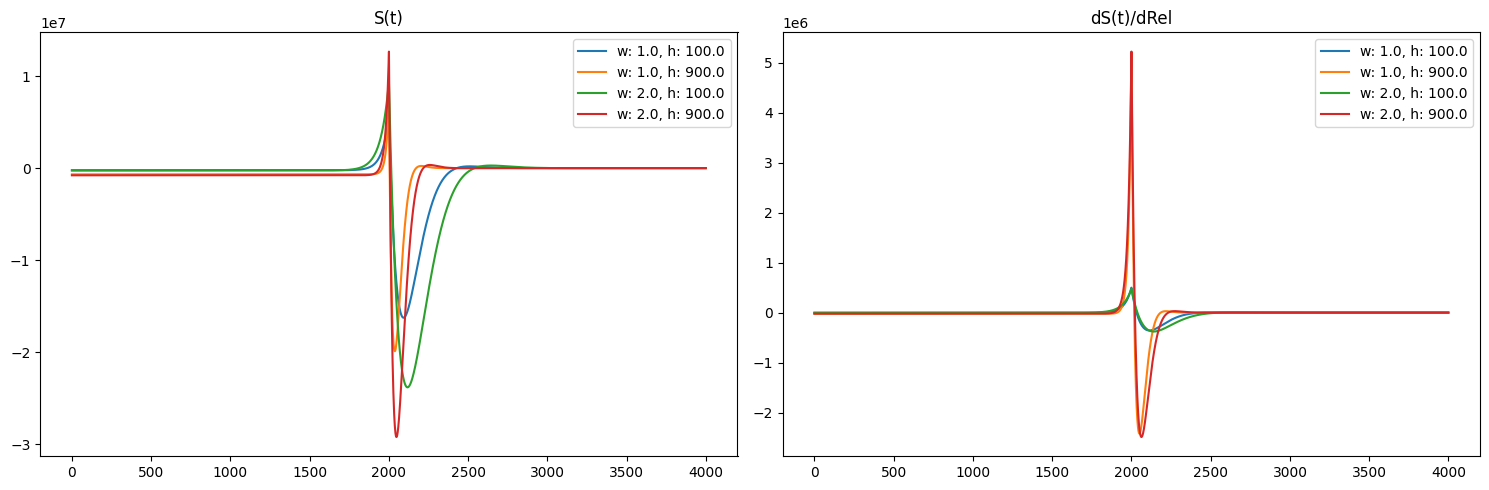

In [79]:

ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['S_t'])
    out[1].append(result['dS_t_dRel'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('S(t)')
axs[1].set_title('dS(t)/dRel')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()

plt.savefig('S_t_dS_t_dRel.png')


# Comparison with Fortran Simulated STF

In [86]:
import pandas as pd
import os


root = os.path.abspath('')
path = f'{root}/data'

filename = 'tdsf_002_train.pickle'
df_train_all = pd.read_pickle(path + '/' + filename)

filename = 'tdsf_002_val.pickle'
df_test_all = pd.read_pickle(path + '/' + filename)

df_data = pd.concat([df_train_all, df_test_all], axis=0)

name_prefix = '_FAR.'
name_material = 'Granite'

df_data = df_data[df_data['material'] == name_prefix + name_material]
df_data = df_data.reset_index(drop=True)

# round YIELD and DEPTH to 2 decimal places
df_data.YIELD = df_data.YIELD.round(2)
df_data.DEPTH = df_data.DEPTH.round(2)

df_data

,delta,b,t4,t5,YIELD,DEPTH,user2,user3,user4,user5,...,unused23,kuser0,sacfilepath,material,DATA,x_mean,x_std,NORM_DATA,NORM_YIELD,NORM_DEPTH
0,0.001,0.0,0.105,0.144,0.71,620.0,694.979919,136.754105,6.017807,0.039,...,0,Granite,/raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000104,0.001168,"[-0.089018986, -0.089018986, -0.089018986, -0....",0.355,0.688889
1,0.001,0.0,0.106,0.149,1.02,620.0,615.920959,121.19735,5.333239,0.043,...,0,Granite,/raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000126,0.001364,"[-0.09263907, -0.09263907, -0.09263907, -0.092...",0.51,0.688889
2,0.001,0.0,0.106,0.152,1.98,840.0,668.94574,97.156403,4.852018,0.046,...,0,Granite,/raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000185,0.002024,"[-0.09140676, -0.09140676, -0.09140676, -0.091...",0.99,0.933333
3,0.001,0.0,0.107,0.165,1.89,500.0,404.404572,98.674721,3.969887,0.058,...,0,Granite,/raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000173,0.001650,"[-0.10481857, -0.10481857, -0.10481857, -0.104...",0.945,0.555556
4,0.001,0.0,0.108,0.169,1.88,440.0,356.50589,98.849365,3.770629,0.061,...,0,Granite,/raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000171,0.001573,"[-0.10843031, -0.10843031, -0.10843031, -0.108...",0.94,0.488889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9581,0.001,0.0,0.108,0.167,1.073,326.0,318.432709,119.168076,4.011763,0.059,...,0,Granite,/raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000123,0.001113,"[-0.11062281, -0.11062281, -0.11062281, -0.110...",0.557982,0.404467
9582,0.001,0.0,0.108,0.167,1.273,366.0,337.705627,112.568542,3.976816,0.059,...,0,Granite,/raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000136,0.001247,"[-0.10929509, -0.10929509, -0.10929509, -0.109...",0.661986,0.454094
9583,0.001,0.0,0.105,0.14,0.423,566.0,753.997009,162.522324,6.885274,0.035,...,0,Granite,/raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000078,0.000908,"[-0.086008616, -0.086008616, -0.086008616, -0....",0.219969,0.702233
9584,0.001,0.0,0.111,0.202,1.073,126.0,123.075226,119.168076,2.699701,0.091,...,0,Granite,/raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...,_FAR.Granite,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000114,0.000804,"[-0.14162812, -0.14162812, -0.14162812, -0.141...",0.557982,0.156328


R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25


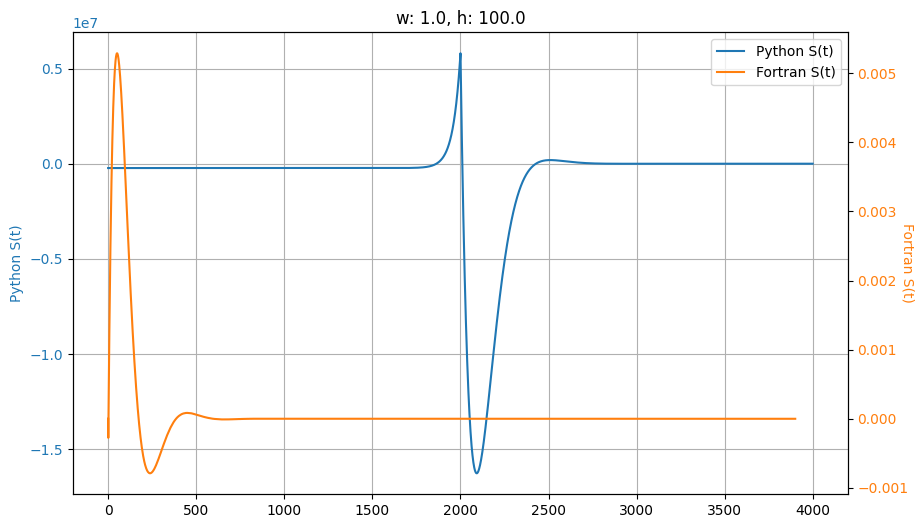

In [81]:
# plot numpy arrays with the DATA column from data_df where YIELD and DEPTH are iterated over from wh_combinations
ws = [1.0]
hs = [100.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[],[],[]]

for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['S_t'])
    out[2].append(result['w'])
    out[3].append(result['h'])

    # find the corresponding YIELD and DEPTH values from the dataframe
    idx = df_data[(df_data['YIELD'] == w) & (df_data['DEPTH'] == h)].index[0]
    out[1].append(df_data.loc[idx, 'DATA'])

    

# plot the S(t) and DATA values for each (W,h) combination
fig, axs = plt.subplots(1, len(wh_combinations), figsize=(10, 6), sharex=True, sharey=False)
plt.grid(True)
for i in range(len(wh_combinations)):
    axs.plot(out[0][i], label=f'Python S(t)', color='tab:blue')
    axs.tick_params(axis='y', labelcolor='tab:blue')
    axs.set_title(f'w: {out[2][i]}, h: {out[3][i]}')
    axs.set_ylabel('Python S(t)', color='tab:blue')
    # make a second axis for the DATA values
    ax2 = axs.twinx()
    ax2.plot(out[1][i][98:], label=f'Fortran S(t)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylabel('Fortran S(t)', color='tab:orange', rotation=270)
    
    
    
    

    # Combine legends
lines_1, labels_1 = axs.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('S_t_comparison.png')

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25


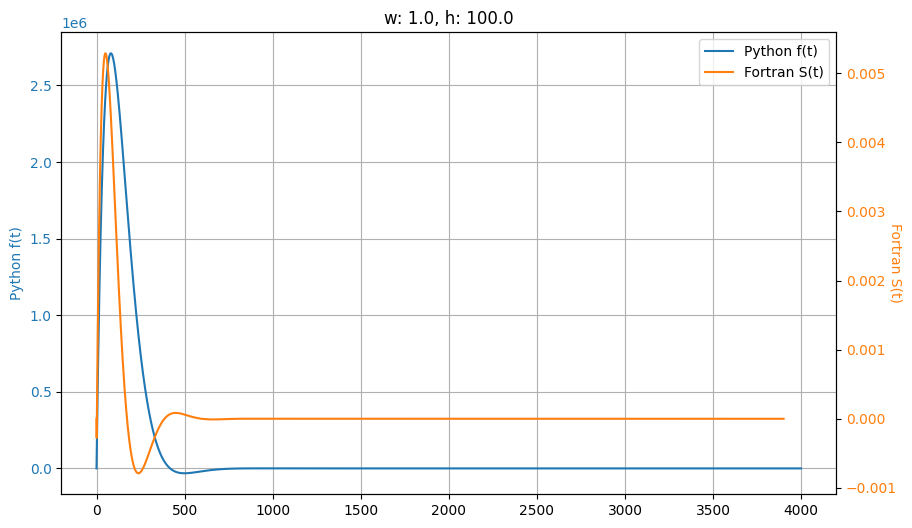

In [82]:
# plot numpy arrays with the DATA column from data_df where YIELD and DEPTH are iterated over from wh_combinations
ws = [1.0]
hs = [100.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[],[],[]]

for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['f_t'])
    out[2].append(result['w'])
    out[3].append(result['h'])

    # find the corresponding YIELD and DEPTH values from the dataframe
    idx = df_data[(df_data['YIELD'] == w) & (df_data['DEPTH'] == h)].index[0]
    out[1].append(df_data.loc[idx, 'DATA'])

    

# plot the S(t) and DATA values for each (W,h) combination
fig, axs = plt.subplots(1, len(wh_combinations), figsize=(10, 6), sharex=True, sharey=False)
plt.grid(True)
for i in range(len(wh_combinations)):
    axs.plot(out[0][i], label=f'Python f(t)', color='tab:blue')
    axs.tick_params(axis='y', labelcolor='tab:blue')
    axs.set_title(f'w: {out[2][i]}, h: {out[3][i]}')
    axs.set_ylabel('Python f(t)', color='tab:blue')
    # make a second axis for the DATA values
    ax2 = axs.twinx()
    ax2.plot(out[1][i][98:], label=f'Fortran S(t)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylabel('Fortran S(t)', color='tab:orange', rotation=270)
    
    
    
    

    # Combine legends
lines_1, labels_1 = axs.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('S_t_vs_f_t_comparison.png')

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25


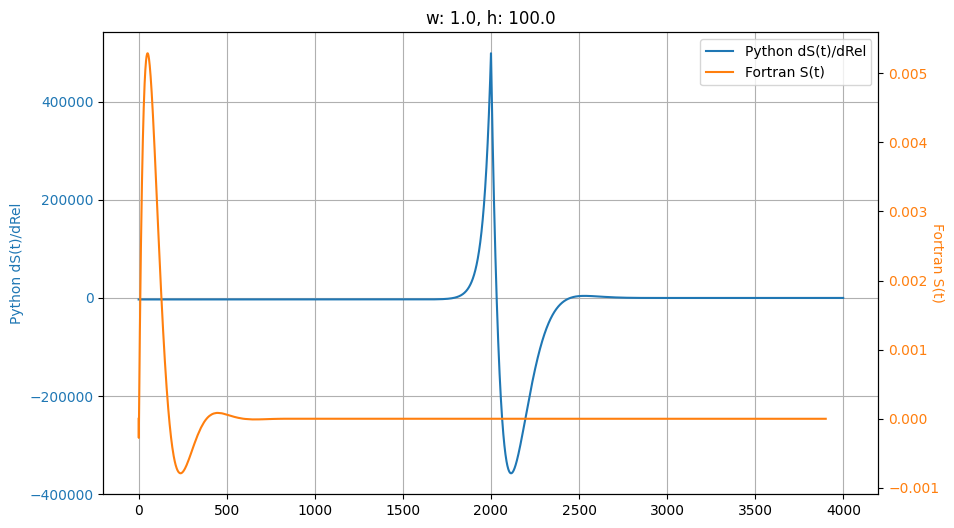

In [83]:
# plot numpy arrays with the DATA column from data_df where YIELD and DEPTH are iterated over from wh_combinations
ws = [1.0]
hs = [100.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[],[],[]]

for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['dS_t_dRel'])
    out[2].append(result['w'])
    out[3].append(result['h'])

    # find the corresponding YIELD and DEPTH values from the dataframe
    idx = df_data[(df_data['YIELD'] == w) & (df_data['DEPTH'] == h)].index[0]
    out[1].append(df_data.loc[idx, 'DATA'])

    

# plot the S(t) and DATA values for each (W,h) combination
fig, axs = plt.subplots(1, len(wh_combinations), figsize=(10, 6), sharex=True, sharey=False)
plt.grid(True)
for i in range(len(wh_combinations)):
    axs.plot(out[0][i], label=f'Python dS(t)/dRel', color='tab:blue')
    axs.tick_params(axis='y', labelcolor='tab:blue')
    axs.set_title(f'w: {out[2][i]}, h: {out[3][i]}')
    axs.set_ylabel('Python dS(t)/dRel', color='tab:blue')
    # make a second axis for the DATA values
    ax2 = axs.twinx()
    ax2.plot(out[1][i][98:], label=f'Fortran S(t)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylabel('Fortran S(t)', color='tab:orange', rotation=270)
    
    
    
    

    # Combine legends
lines_1, labels_1 = axs.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('S_t_vs_dSdRel_comparison.png')

# Implementing STF PINN

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
device='cpu'


# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    "Salt": {
        "h0": 122.0, "R0": 478.0, "gamma0": 31.0, "P10": 5.5E6, "P20": 0.8E6, "pv": 4670.0, "sv": 2696.0, "n": 1.87, "rho": 2200.0
    },
    "Shale": {
        "h0": 122.0, "R0": 265.0, "gamma0": 42.0, "P10": 4.2E6, "P20": 2.5E6, "pv": 4320.0, "sv": 2495.0, "n": 2.4, "rho": 2350.0
    },
    "Wet Tuff": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 2400.0, "sv": 1300.0, "n": 2.4, "rho": 1915.0
    },
    "Wet Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5350.0, "sv": 2795.0, "n": 2.4, "rho": 2650.0
    }
}


material = 'Granite'

# Function to populate variables from the dictionary based on material name
def get_constants(material_name, device):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        h0 = torch.tensor(material_constants["h0"], requires_grad=False, device=device)
        R0 = torch.tensor(material_constants["R0"], requires_grad=False, device=device)
        gamma0 = torch.tensor(material_constants["gamma0"], requires_grad=False, device=device)
        P10 = torch.tensor(material_constants["P10"], requires_grad=False, device=device)
        P20 = torch.tensor(material_constants["P20"], requires_grad=False, device=device)
        pv = torch.tensor(material_constants["pv"], requires_grad=False, device=device)
        sv = torch.tensor(material_constants["sv"], requires_grad=False, device=device)
        n = torch.tensor(material_constants["n"], requires_grad=False, device=device)
        rho = torch.tensor(material_constants["rho"], requires_grad=False, device=device)
        return h0, R0, gamma0, P10, P20, pv, sv, n, rho
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)

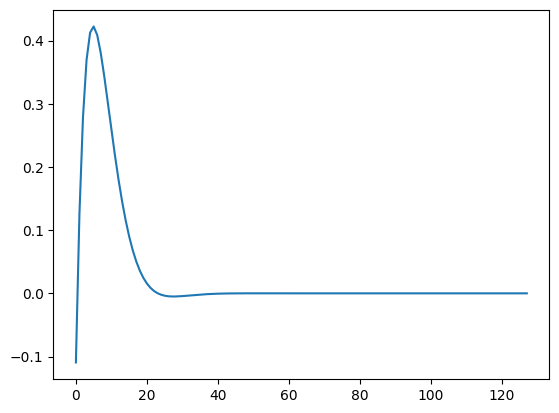

In [4]:

def stf(t,w,h): 

    b = 1

    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu  

    def Heaviside(t):
        return torch.where(t > 0, torch.tensor(1.0), torch.tensor(0.0))

    # Define H(t), Heaviside step function
    H_t = Heaviside(t)

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lam + 2 * mu) / (4 * mu)

    # Compute w0 based on the given equation
    w0 = pv / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    p = w0 * torch.sqrt(1 / (2 * beta) - 1 / (4 * beta**2))

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)

    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv**2 / (beta * p))
        return A * H_t * torch.exp(-alpha * t) * (-alpha * torch.sin(p * t) + p * torch.cos(p * t))

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t


    def dB_t_dRel():
        term1 = -torch.exp(-gamma * t) * P10 * (h / h0) * (t * gamma / R_el - n / R_el * (h / h0).pow(1/n)) * (h * w.pow(-1/3)).pow(1/3)
        term2 = P20 * w.pow(0.87) * ((t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3) - (t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3))
        term3 = (1 - torch.exp(-gamma * t)) * (1 / 3 * n * R0.pow(2) / R_el.pow(3) * (h0 / h).pow(1/3) * w.pow(-2/3) * (h * w.pow(-1/3)).pow(1/3))
        term4 = (1 - torch.exp(-gamma * t)) * (-3 * R0.pow(3) / R_el.pow(4) * (h0 / h).pow(1/3) * (h * w.pow(-1/3)).pow(1/3))
        return (term1 + term2 + term3 + term4) * H_t


    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h).pow(1/n) * (1 / 3) * w.pow(-2/3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h).pow(1/n) * (1 / h) * w.pow(1/3)

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)


    # Reshape for conv1d: [batch_size, channels, sequence_length]
    df_dt_reshaped = df_dt.view(b, 1, -1)

    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(b, 1, -1)

    S_t = F.conv1d(-df_dt_reshaped/(R_el*pv), B_t_reshaped, padding=B_t_reshaped.size(-1)-1) # full convolution padding
    S_t = S_t.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t

    dB_t_dRel_val = dB_t_dRel()
    dB_t_dRel_reshaped = dB_t_dRel_val.view(b, 1, -1)

    # Perform convolution using conv1d
    dS_t_dRel = F.conv1d(-df_dt_reshaped/(R_el*pv), dB_t_dRel_reshaped, padding=dB_t_dRel_reshaped.size(-1)-1) # full convolution padding
    dS_t_dRel = dS_t_dRel.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t


    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    # Compute dS(t)/dW and dS(t)/dh using autograd
    # dS_dW_num = torch.autograd.grad(S_t.sum(), w, create_graph=True)[0]
    # dS_dh_num = torch.autograd.grad(S_t.sum(), h, create_graph=True)[0]

    return S_t, dS_dW_ana.sum(), dS_dh_ana.sum()
batch_size = 1
# Define h, w, t as tensors with requires_grad=True to compute derivatives
h,w = Variable(torch.tensor(150.0, device=device), requires_grad=True), Variable(torch.tensor(1.0, device=device), requires_grad=True)
t = torch.linspace(0, 2.0, steps=128, requires_grad=True, device=device)
S_t, dS_dW_ana, dS_dh_ana = stf(t,w,h)
plt.plot(S_t.detach().cpu().numpy())

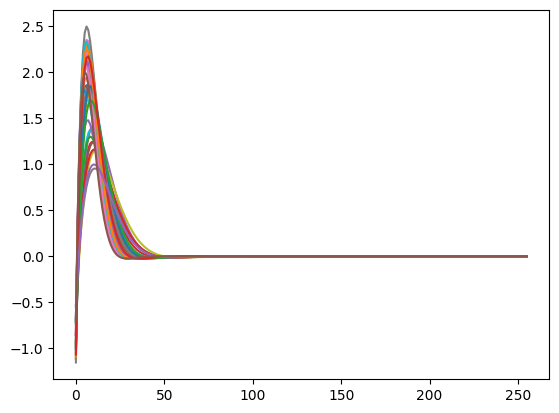

In [5]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)

def stf_batch(t,w,h): 

    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu  

    def Heaviside(t):
        return torch.where(t > 0, torch.tensor(1.0), torch.tensor(0.0))

    # Define H(t), Heaviside step function
    H_t = Heaviside(t)

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lam + 2 * mu) / (4 * mu)

    # Compute w0 based on the given equation
    w0 = pv / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    p = w0 * torch.sqrt(1 / (2 * beta) - 1 / (4 * beta**2))

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)

    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv**2 / (beta * p))
        return A * H_t * torch.exp(-alpha * t) * (-alpha * torch.sin(p * t) + p * torch.cos(p * t))

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t


    def dB_t_dRel():
        term1 = -torch.exp(-gamma * t) * P10 * (h / h0) * (t * gamma / R_el - n / R_el * (h / h0).pow(1/n)) * (h * w.pow(-1/3)).pow(1/3)
        term2 = P20 * w.pow(0.87) * ((t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3) - (t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3))
        term3 = (1 - torch.exp(-gamma * t)) * (1 / 3 * n * R0.pow(2) / R_el.pow(3) * (h0 / h).pow(1/3) * w.pow(-2/3) * (h * w.pow(-1/3)).pow(1/3))
        term4 = (1 - torch.exp(-gamma * t)) * (-3 * R0.pow(3) / R_el.pow(4) * (h0 / h).pow(1/3) * (h * w.pow(-1/3)).pow(1/3))
        return (term1 + term2 + term3 + term4) * H_t


    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h).pow(1/n) * (1 / 3) * w.pow(-2/3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h).pow(1/n) * (1 / h) * w.pow(1/3)

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)


    # Reshape for conv1d: [batch_size, channels, sequence_length]
    df_dt_reshaped = df_dt.view(1, b, -1)

    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(b, 1, -1)

    S_t = F.conv1d(-df_dt_reshaped/(R_el*pv), B_t_reshaped, 
                   padding=B_t_reshaped.size(-1)-1, groups=b) # full convolution padding
    S_t = S_t.view(b, -1)[:, t.size(-1)-1:]  # Ensure S_t has the same length as t

    dB_t_dRel_val = dB_t_dRel()
    dB_t_dRel_reshaped = dB_t_dRel_val.view(b, 1, -1)

    # Perform convolution using conv1d
    dS_t_dRel = F.conv1d(-df_dt_reshaped/(R_el*pv), dB_t_dRel_reshaped, 
                         padding=B_t_reshaped.size(-1)-1, groups=b) # full convolution padding
    dS_t_dRel = dS_t_dRel.view(b,-1)[:, t.size(-1)-1:]  # Ensure S_t has the same length as t


    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    # Compute dS(t)/dW and dS(t)/dh using autograd
    # dS_dW_num = torch.autograd.grad(S_t.sum(), w, create_graph=True)[0]
    # dS_dh_num = torch.autograd.grad(S_t.sum(), h, create_graph=True)[0]

    return S_t, dS_dW_ana, dS_dh_ana

b = 36
# Define h, w, t as tensors with requires_grad=True to compute derivatives
h = Variable(torch.tensor(np.random.uniform(150., 900., b), device=device), requires_grad=True).view(b,-1)
w = Variable(torch.tensor(np.random.uniform(1., 2., b), device=device), requires_grad=True).view(b,-1)
t = torch.linspace(0, 2.0, steps=256, requires_grad=True, device=device).repeat(b).view(b,-1)
S_t, dS_dW_ana, dS_dh_ana = stf_batch(t,w,h)

for i in range(b):
    plt.plot(S_t[i].detach().cpu().numpy())
plt.show()



In [6]:
import torch.nn as nn
import torch.optim as optim
from kanunet import KANU_Net

device = 'cuda'


# Define the seeds
base_seed = 42  # You can choose any seed value
torch.manual_seed(base_seed)
np.random.seed(base_seed)


# Define the Neural Network class
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, act, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Output activation function
        self.output_activation = torch.nn.Identity()
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = act
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_activation(self.output_layer(x))

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

from layers import KANLinear

class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=10,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.ReLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


# # Setup model and optimizer.
# model = NeuralNet(input_dimension=1, 
#                   output_dimension=1, 
#                   n_hidden_layers=6, 
#                   neurons=256,
#                   act = torch.nn.ReLU(), # torch.nn.Tanh(), torch.nn.ReLU(), torch.nn.GELU()
#                   regularization_param=0.5, 
#                   regularization_exp=2,
#                   retrain_seed=128).to(device)

# model = KAN([1, 64, 32, 16, 8, 16, 32, 64, 1]).to(device)
model = KANU_Net(1, 1, 'mps').to(device)
# Training params
lr = 1.E-3

# Select Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=30, threshold=1E-3, 
                                                 threshold_mode='rel', cooldown=0, min_lr=1E-8, eps=1E-8, verbose=True)

material = 'Salt' # Granite, Salt, Shale, Wet Tuff, Wet Granite

b = 512
nt = 96
tmax = .5
tmin = 0.0
n_iter = 512
model.train()
losses = [[],[],[],[]]

h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)

hmin = 150.
hmax = 900.
wmin = 1.
wmax = 2.

lam_w = 1E-6
lam_h = 1E-5
lam_p = 1E-3

# Define h, w, t as tensors with requires_grad=True to compute derivatives
h = Variable(torch.tensor(np.random.uniform(hmin, hmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
w = Variable(torch.tensor(np.random.uniform(wmin, wmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
t = torch.linspace(tmin, tmax, steps=nt, requires_grad=True, device=device).repeat(b).view(b,-1)

S_t, dS_dW, dS_dh = stf_batch(t,w,h)

hnorm = (h/hmax).squeeze().repeat(nt).view(b,-1)
wnorm = (w/wmax).squeeze().repeat(nt).view(b,-1)
tnorm = t/tmax

x = (tnorm*wnorm*hnorm).view(b,-1,1)
# x = torch.stack((tnorm,wnorm,hnorm)).view(b,-1,3)

smax, smin = S_t.max(axis=-1, keepdim=True).values, S_t.min(axis=-1, keepdim=True).values
# xmax, xmin = x.max(axis=1, keepdim=True).values, x.min(axis=1, keepdim=True).values
xmax, xmin = x.max(), x.min()

s = model(((x - xmin)/(xmax - xmin)))
s = s.squeeze()*(smax - smin) + smin


print(x.shape, s.shape, S_t.shape, dS_dW.shape, dS_dh.shape)

# for i in range(b):
#     plt.plot(S_t[i].detach().cpu().numpy())
# plt.show()

def zero_one_normalize(x, seq_axis=1):
    """
    normalizes a batch of time-series data to the range [0, 1]
    x: torch.Tensor of shape (batch_size, sequence_length, 1)
    """
    xmax = x.max(axis=seq_axis, keepdim=True).values
    xmin = x.min(axis=seq_axis, keepdim=True).values

    return (x - xmin)/(xmax - xmin)


def find_peak_timesteps(data):
    """
    Find the timesteps at which each curve in the batch peaks.
    
    Args:
        data (torch.Tensor): Tensor of shape (batch_size, seq_length)
        
    Returns:
        torch.Tensor: Tensor of shape (batch_size,) containing the peak timesteps for each curve.
    """
    peak_timesteps = torch.argmax(data, dim=1)
    return peak_timesteps.float()


lrs = []
for i in range(n_iter):


    # Set the seed for the current iteration
    current_seed = base_seed + i
    torch.manual_seed(current_seed)
    np.random.seed(current_seed)
    
    optimizer.zero_grad()
    loss = torch.tensor(0.0, device=device)
    # Define h, w, t as tensors with requires_grad=True to compute derivatives
    h = Variable(torch.tensor(np.random.uniform(hmin, hmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
    w = Variable(torch.tensor(np.random.uniform(wmin, wmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
    t = torch.linspace(tmin, tmax, steps=nt, requires_grad=True, device=device).repeat(b).view(b,-1)

    S_t, dS_dW, dS_dh = stf_batch(t,w,h)

    hnorm = (h/hmax).squeeze().repeat(nt,1).T.view(b,-1)
    wnorm = (w/wmax).squeeze().repeat(nt,1).T.view(b,-1)
    tnorm = t/tmax

    x = (tnorm*wnorm*hnorm).view(b,-1,1)
    # x = torch.stack((tnorm,wnorm,hnorm)).view(b,-1,3)
    
    smax, smin = S_t.max(axis=-1, keepdim=True).values, S_t.min(axis=-1, keepdim=True).values
    xmax, xmin = x.max(axis=1, keepdim=True).values, x.min(axis=1, keepdim=True).values

    s = model(((x - xmin)/(xmax - xmin)))
    s = s.squeeze()*(smax - smin) + smin
    # s = model(((x - xmin)/(xmax - xmin)).mT) # if KANU_Net is used
    # s = s.mT.squeeze()*(smax - smin) + smin # if KANU_Net is used

    loss_d = torch.mean((s.squeeze() - S_t )**2)

    # # boundary loss
    l_t0 = s[:,0] - S_t[:,0]
    l_tL = s[:,-1] - S_t[:,-1]
    loss_b = torch.mean(l_t0**2) + torch.mean(l_tL**2)
    
    # peak loss
    l_tp = (find_peak_timesteps(s) - find_peak_timesteps(S_t))/nt
    loss_p = lam_p*torch.mean(l_tp**2)

    s_w = torch.autograd.grad(s.sum(), wnorm, create_graph=True)[0]
    s_h = torch.autograd.grad(s.sum(), hnorm, create_graph=True)[0]

    loss_sw = lam_w*torch.mean((s_w - dS_dW)**2)
    loss_sh = lam_h*torch.mean((s_h - dS_dh)**2)

    # loss_sw = lam_w*torch.mean(s_w**2)
    # loss_sh = lam_h*torch.mean(s_h**2)


    loss += loss_d
    loss += loss_b
    # loss += loss_p
    loss += loss_sw
    loss += loss_sh

    losses[0].append(loss_d.item())
    losses[1].append(loss_sw.item())
    losses[2].append(loss_sh.item())

    lrs.append(scheduler._last_lr)
    
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    print(f'Iteration: {i}, Loss: {loss.item():.3f}, Loss_d: {loss_d.item():.3f}, Loss_sw: {loss_sw.item():.3f}, Loss_sh: {loss_sh.item():.3f}')

# plot losses
fig = plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(losses[0], label='Data Loss')
plt.plot(losses[1], label='dS/dW Loss')
plt.plot(losses[2], label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('MSE', fontsize=16, fontweight='bold')
plt.legend()
plt.show()



# plot learning rate schedule
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yscale('log')
plt.plot(lrs)
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Learning Rate', fontsize=16, fontweight='bold')




# Evaluate the model
b = 16
h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)
# Define h, w, t as tensors with requires_grad=True to compute derivatives
h = Variable(torch.tensor(np.random.uniform(hmin, hmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
w = Variable(torch.tensor(np.random.uniform(wmin, wmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
t = torch.linspace(tmin, tmax, steps=nt, requires_grad=True, device=device).repeat(b).view(b,-1)
S_t, dS_dW_ana, dS_dh_ana = stf_batch(t,w,h)

hnorm = (h/hmax).squeeze().repeat(nt,1).T.view(b,-1)
wnorm = (w/wmax).squeeze().repeat(nt,1).T.view(b,-1)
tnorm = t/tmax

x = (tnorm*wnorm*hnorm).view(b,-1,1)
# x = torch.stack((tnorm,wnorm,hnorm)).view(b,-1,3)
xmax, xmin = x.max(axis=1, keepdim=True).values, x.min(axis=1, keepdim=True).values
smax, smin = S_t.max(axis=-1, keepdim=True).values, S_t.min(axis=-1, keepdim=True).values
model.eval()

s = model(((x - xmin)/(xmax - xmin)))
s = s.squeeze()*(smax - smin) + smin

# s = model(((x - xmin)/(xmax - xmin)).mT)
# s = s.mT.squeeze()*(smax - smin) + smin

# yield vs depth plot
fig = plt.figure(figsize=(10, 6))
mse = np.mean((S_t.squeeze().detach().cpu().numpy() - s.squeeze().detach().cpu().numpy())**2, axis=-1)
plt.scatter(x=w[:,-1].squeeze().detach().cpu().numpy(), 
            y=h[:,-1].squeeze().detach().cpu().numpy(), 
            c=np.log(mse), cmap='turbo', alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('Yield', fontsize=16, fontweight='bold')
plt.ylabel('Depth', fontsize=16, fontweight='bold')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
axs.ravel()
[i.grid(True) for i in axs]


cmap = plt.get_cmap('tab20')
c = np.array([np.log(mse[i]) for i in range(b)])

axs[0].set_title(f'Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title(f'Predicted S(t)', fontsize=16, fontweight='bold')
for i in range(b):
    axs[0].plot(S_t[i].detach().cpu().numpy())
    axs[1].plot(s[i].squeeze().detach().cpu().numpy())
plt.tight_layout()
plt.show()



# Assuming true_data and predicted_data are your datasets
# true_data and predicted_data should have shape (num_curves, num_timesteps)
# For demonstration purposes, let's create some dummy data
num_curves = 100
num_timesteps = 250

# Dummy data (Replace these with your actual data)
true_data = np.random.rand(num_curves, num_timesteps) * np.exp(-0.02*np.arange(num_timesteps)) * 40
predicted_data = np.random.rand(num_curves, num_timesteps) * np.exp(-0.02*np.arange(num_timesteps)) * 40

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t.squeeze().detach().cpu().numpy(), axis=1)
predicted_peaks = np.argmax(s.squeeze().detach().cpu().numpy(), axis=1)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)')
plt.xlabel('Timesteps')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)')
plt.xlabel('Timesteps')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: Given groups=1, weight of size [32, 4, 3], expected input[512, 384, 1] to have 4 channels, but got 384 channels instead